# Economic Dispatch

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\fenya\Documents\BEE4750\Project\FP-Group6`


In [2]:
Pkg.add("Plots")

    Updating registry at `C:\Users\fenya\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Project.toml`
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Manifest.toml`


In [3]:
using JuMP
using HiGHS

In [4]:
Pkg.add("HiGHS")

   Resolving package versions...
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Project.toml`
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Manifest.toml`


In [5]:
Pkg.add("JuMP")
Pkg.add("CSV")
Pkg.add("MarkdownTables")
Pkg.add("Dates")

Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("Measures")


# using DataFrames
# using Plots
# using Measures

   Resolving package versions...
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Project.toml`
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Project.toml`
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Project.toml`
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Project.toml`
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Project.toml`
  No Changes to `C:\Users\fenya\Documents\BEE4750\Project\FP-Group6\Manifest.toml`
   Resolvi

In [6]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables
# using NamedArrays
using Dates

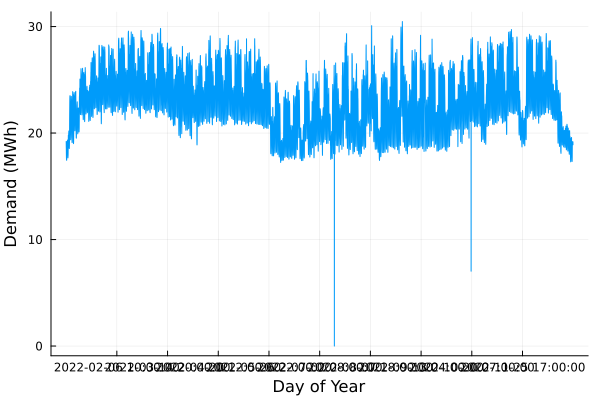

In [7]:
# load the data, pull Zone C, and reformat the DataFrame
CU_edemand = DataFrame(CSV.File("data/Cornell_Electricity_Data.csv"))
rename!(CU_edemand, :"slottime_GMT" => :Date)
edemand = CU_edemand[:, [:Date, :slotavg]]
rename!(edemand, :slotavg => :edemand)
# demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(edemand.Date, edemand.edemand, xlabel="Day of Year", ylabel="Demand (MWh)", label=:false)

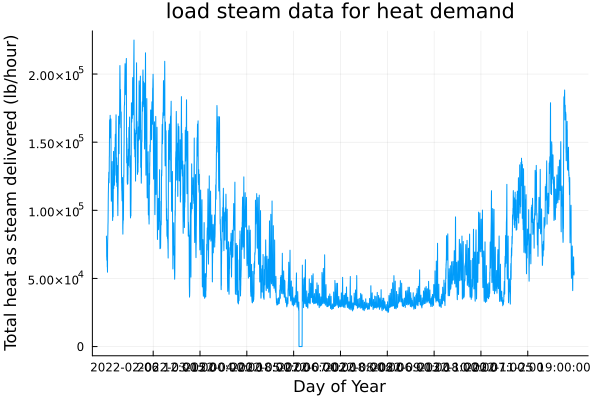

In [8]:
# load steam data for heat demand
CU_hdemand = DataFrame(CSV.File("data/Cornell_steam_data.csv"))
rename!(CU_hdemand, :"slottime_GMT" => :Date)
hdemand = CU_hdemand[:, [:Date, :slotavg]]
rename!(hdemand, :slotavg => :hdemand)

# Converting to units of MMBTU of heat produced (before distribution losses)

# plot demand
plot(hdemand.Date, hdemand.hdemand, title="load steam data for heat demand", xlabel="Day of Year", ylabel="Total heat as steam delivered (lb/hour)", label=:false)

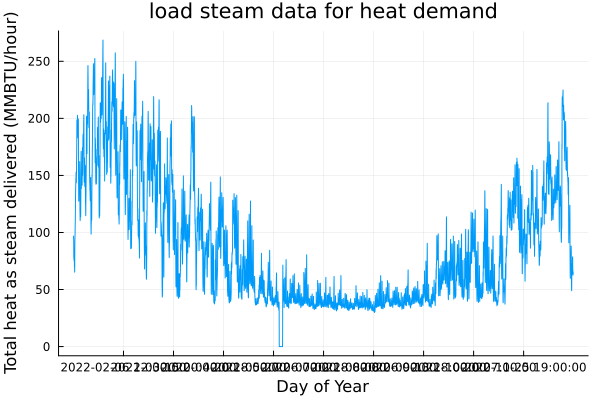

In [9]:
# load steam data for heat demand
CU_hdemand = DataFrame(CSV.File("data/Cornell_steam_data.csv"))
rename!(CU_hdemand, :"slottime_GMT" => :Date)
hdemand = CU_hdemand[:, [:Date, :slotavg]]
rename!(hdemand, :slotavg => :hdemand)

# Converting to units of MMBTU of heat produced (before distribution losses)
hdemand.hdemand = hdemand.hdemand*0.001194
# demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(hdemand.Date, hdemand.hdemand, title="load steam data for heat demand", xlabel="Day of Year", ylabel="Total heat as steam delivered (MMBTU/hour)", label=:false)

In [10]:
hdemand.hdemand

8752-element Vector{Float64}:
 96.795368115
 95.045805885
 95.13357981
 93.852176025
 88.35585672
 78.72725266500001
 78.75524300999999
 77.462203695
 75.645467025
 79.375815555
  ⋮
 68.72027001
 66.368433285
 66.65727681
 65.19214926
 62.68227768
 63.703807364999996
 63.56257805999999
 64.77608802
 65.333444235

In [11]:
maximum(hdemand.hdemand)

268.5791958

In [12]:
30/maximum(hdemand.hdemand)

0.11169889726805118

In [13]:
# Information about different generation and heating sources
# gens is electricity - natural gas is CHP 
# -- heat pumps run on electricity and produce heat
gens = DataFrame(CSV.File("data/Gen_data_CU.csv"))

# heat is heat
heat = DataFrame(CSV.File("data/Heat_data_CU.csv"))

Row,Column1,Capacity,VarCost,Emissions,Conversion Factor (MWh/MMBTU)
,String3,Int64?,Float64?,Float64?,Float64
1,NG,30,27.5345,0.575831,0.0837521
2,HPs,100,0.0,0.0,0.0814086
3,ESH,missing,missing,missing,0.025708


In [14]:
gens

Row,Column1,Capacity,VarCost,Emissions
,String7,Int64,Float64,Float64
1,NG,30,27.5345,0.575831
2,Solar,138,0.0,0.0


In [15]:
# Electricity production conversion (MWh/MMBtu), assumed constant
# Natural gas - electricity produced per heat
# Heat Pumps - electricity required per heat
heat.Conversion_Factor

ArgumentError: ArgumentError: column name :Conversion_Factor not found in the data frame

Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

In [16]:
[Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)]

8736-element Vector{DateTime}:
 2022-01-01T00:00:00
 2022-01-01T01:00:00
 2022-01-01T02:00:00
 2022-01-01T03:00:00
 2022-01-01T04:00:00
 2022-01-01T05:00:00
 2022-01-01T06:00:00
 2022-01-01T07:00:00
 2022-01-01T08:00:00
 2022-01-01T09:00:00
 ⋮
 2022-12-31T15:00:00
 2022-12-31T16:00:00
 2022-12-31T17:00:00
 2022-12-31T18:00:00
 2022-12-31T19:00:00
 2022-12-31T20:00:00
 2022-12-31T21:00:00
 2022-12-31T22:00:00
 2022-12-31T23:00:00

In [17]:
transform(edemand, :Date => (ByRow(t -> Dates.DateTime(t, dateformat"yyyy-mm-dd HH:MM:SS"))) => :Date)

Row,Date,edemand
,DateTime,Float64
1,2022-01-01T00:00:00,19.2144
2,2022-01-01T01:00:00,18.705
3,2022-01-01T02:00:00,18.5034
4,2022-01-01T03:00:00,18.0225
5,2022-01-01T04:00:00,17.6864
6,2022-01-01T05:00:00,17.6017
7,2022-01-01T06:00:00,17.4555
8,2022-01-01T07:00:00,17.6025
9,2022-01-01T08:00:00,17.4436


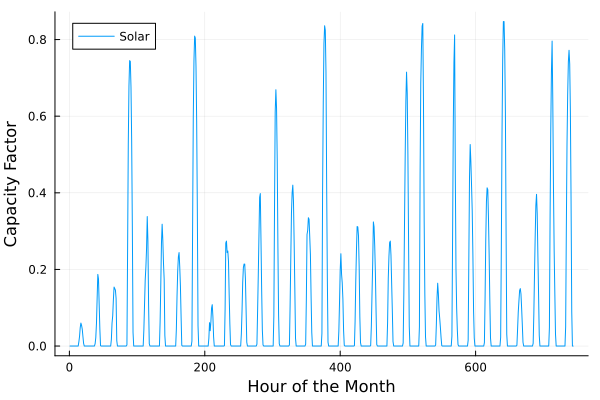

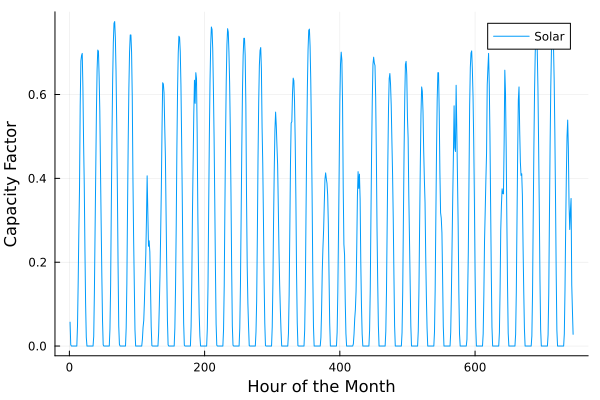

In [18]:
cap_factor = DataFrame(CSV.File("data/2022_solar_CF_zone_C.csv", header=4))
cap_factor=  cap_factor[:, [:time, :electricity]]
rename!(cap_factor, :electricity => :Solar)

# plot January capacity factors
# p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
p1 = plot(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

# p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
p2 = plot(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

## Drop missing data

In [19]:
e_missing_dates = setdiff(DateTime(2022, 1, 1, 0):Hour(1):DateTime(2022, 12, 31, 23),[Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)])
h_missing_dates = setdiff(DateTime(2022, 1, 1, 0):Hour(1):DateTime(2022, 12, 31, 23),[Dates.DateTime(hdemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(hdemand.Date)])
cap_factor = DataFrame(CSV.File("data/2022_solar_CF_zone_C.csv", header=4))
cap_factor=  cap_factor[:, [:time, :electricity]]
rename!(cap_factor, :electricity => :Solar)
missing_dates = [h_missing_dates; e_missing_dates]
e_dts = [Dates.DateTime(edemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(edemand.Date)]
h_dts = [Dates.DateTime(hdemand.Date[i], dateformat"yyyy-mm-dd HH:MM:SS") for i in 1:length(hdemand.Date)]
cf_dts = [Dates.DateTime(cap_factor.time[i], dateformat"mm/dd/yyyy HH:MM") for i in 1:length(cap_factor.time)]
cap_factor = cap_factor[[cf_dts[i] ∉ missing_dates for i in 1:length(cap_factor.time)],:]
edemand = edemand[[e_dts[i] ∉ missing_dates for i in 1:length(edemand.Date)],:]
hdemand = hdemand[[h_dts[i] ∉ missing_dates for i in 1:length(hdemand.Date)],:]

Row,Date,hdemand
,String31,Float64
1,2022-01-01 00:00:00,96.7954
2,2022-01-01 01:00:00,95.0458
3,2022-01-01 02:00:00,95.1336
4,2022-01-01 03:00:00,93.8522
5,2022-01-01 04:00:00,88.3559
6,2022-01-01 05:00:00,78.7273
7,2022-01-01 06:00:00,78.7552
8,2022-01-01 07:00:00,77.4622
9,2022-01-01 08:00:00,75.6455


## Solutions

Scenario 1 (no heating constraint)

Decision variables:
$x_{g}$ = Installed capacity for generator type g (MW)

$y_{g,t}$ = Production from generator g in time t (MWh)

$NSE_{t}$ = non-served energy in time t (MWh)

Minimize total cost = fixed cost + variable cost + unserved energy cost
\begin{align}
\min_{x, y, NSE} \quad & \sum_{g \in \mathcal{G}} \text{FixedCost}_g \times x_g + \sum_{t \in \mathcal{T}} \sum_{g \in \mathcal{G}} \text{VarCost}_g \times y_{g,t} & \\
& \quad + \sum_{t \in \mathcal{T}} \text{NSECost} \times NSE_t & \\[0.5em]
\text {subject to:} \quad & \sum_{g \in \mathcal{G}} y_{g,t} + NSE_t \geq d_t \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Meeting demand in each hour)} \\
& y_{g,t} \leq x_g*c_{g,t} \qquad \qquad \qquad\qquad  \forall g \in {G},  \forall t \in \mathcal{T} \\[0.5em]
\text{(Generator capacity limits)} \\
& x_g, y_{g,t}, NSE_t \geq 0 \qquad \qquad \forall g \in {G},  \forall t \in \mathcal{T}
\end{align}

Economic Dispatch with CHP

Decision variables:

$y_{g,t}$ = Production from generator g in time t (MWh)

$z_{s,t}$ = Heat production from source s in time t (MWh)

$NSE_{t}$ = non-served energy in time t (MWh)

Parameters:

r = Conversion factor for CHP, MWh produced per MMBTU produced

$c_{hp,t}$ = Conversion factor for heat pump, MWh required per MMBTU produced


Minimize total cost = fixed cost + variable cost + unserved energy cost
\begin{align}
\sum_{t \in \mathcal{T}} \sum_{g \in \mathcal{G}} \text{VarCost}_g \times y_{g,t} \quad + \sum_{t \in \mathcal{T}} \text{NSECost} \times NSE_t & \\[0.5em]
\text {subject to:} \quad & \sum_{g \in \mathcal{G}} y_{g,t} + NSE_t \geq d_t + c_{hp,t}* z_{hp,t} \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Meeting demand in each hour)} \\
\quad & \sum_{s \in \mathcal{S}} h_{s,t} \geq zd_t \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Meeting heating demand in each hour)} \\
\quad & z_{n,t} = r*y_{n,t} \qquad \forall t \in \mathcal{T} \\[0.5em]
\text{(Assume constant ratio of heat to electricty production from natural gas)} \\
& y_{g,t} \leq x_g*c_{g,t} \qquad \qquad \qquad\qquad  \forall g \in {G},  \forall t \in \mathcal{T} \\[0.5em]
\text{(Generator capacity limits)} \\
& x_g, y_{g,t}, NSE_t \geq 0 \qquad \qquad \forall g \in {G},  \forall t \in \mathcal{T}
\end{align}

In [20]:
# capacity factor for gas will be 1 --> this sets the capacity factor as 1 for every day of the year
cap_factor[:, :Gas] .=1

# cap_factor[:, :Geothermal] .=0.8
# cap_factor[:, :NG_CCGT] .=1
# cap_factor[:, :NG_CT] .=1

# all capacity factors together into one data frame
select!(cap_factor, :Gas, :Solar)

Row,Gas,Solar
,Int64,Float64
1,1,0.0
2,1,0.0
3,1,0.0
4,1,0.0
5,1,0.0
6,1,0.0
7,1,0.0
8,1,0.0
9,1,0.0


In [21]:
# No heat, Just electricity no heatpumps
# define sets
G = 1:nrow(gens)
T = 1:nrow(edemand)
NSECost = 10000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    NSE[t in T] >= 0
end)

(2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, 1:2
    Dimension 2, 1:8736
And data, a 2×8736 Matrix{VariableRef}:
 y[1,1]  y[1,2]  y[1,3]  y[1,4]  y[1,5]  …  y[1,8734]  y[1,8735]  y[1,8736]
 y[2,1]  y[2,2]  y[2,3]  y[2,4]  y[2,5]     y[2,8734]  y[2,8735]  y[2,8736], 1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, 1:8736
And data, a 8736-element Vector{VariableRef}:
 NSE[1]
 NSE[2]
 NSE[3]
 NSE[4]
 NSE[5]
 NSE[6]
 NSE[7]
 NSE[8]
 NSE[9]
 NSE[10]
 ⋮
 NSE[8728]
 NSE[8729]
 NSE[8730]
 NSE[8731]
 NSE[8732]
 NSE[8733]
 NSE[8734]
 NSE[8735]
 NSE[8736])

In [22]:
# Optimizing cost (cost is constant over time per mwh) of just electricity

# define sets
G = 1:nrow(gens)
T = 1:nrow(edemand)
NSECost = 10000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    NSE[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE)
)

@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)



Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [3e+01, 1e+04]
  Bound  [0e+00, 0e+00]
  RHS    [1e-01, 1e+02]
Presolving model
8735 rows, 17470 cols, 17470 nonzeros  0s
5993 rows, 11986 cols, 11986 nonzeros  0s
Presolve : Reductions: rows 5993(-20215); columns 11986(-14222); elements 11986(-31694)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 5993(117375) 1s
       5993     3.2318777195e+06 Pr: 0(0) 2s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 5993
Objective value     :  3.2318777195e+06
Relative P-D gap    :  5.7633527964e-16
HiGHS run time      :          1.87


In [23]:
NoHeat_cost = @show objective_value(gencap)

objective_value(gencap) = 3.2318777194890766e6


3.2318777194890766e6

Objective value wihtout heat is $4476878

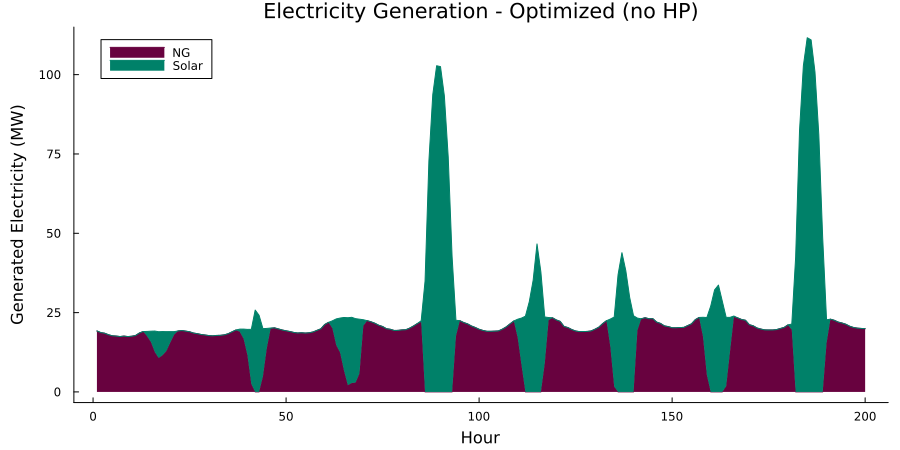

In [24]:
# Plotting natural gas and solar generation at the optimized cost
# This is just optimizing to meet electricity demand

gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=permutedims(gens[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, title = "Electricity Generation - Optimized (no HP)", legendcolumns=1, leftmargin=5mm, bottommargin=3mm)
plot!(p, size=(900, 450))

## No heat pumps, electricity as only constrain, optimizing for emissions

In [25]:
# Optimizing emissions just electricity

# define sets
G = 1:nrow(gens)
T = 1:nrow(edemand)
NSECost = 10000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :Emissions] .* sum(y[:, t] for t in T))
)

@constraint(gencap, load[t in T], sum(y[:, t]) >= edemand.edemand[t])

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)



Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [6e-01, 6e-01]
  Bound  [0e+00, 0e+00]
  RHS    [1e-01, 1e+02]
Presolving model
4380 rows, 4380 cols, 4380 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-26208); columns 0(-17472); elements 0(-34944) - Reduced to empty
Solving the original LP from the solution after postsolve
Model status        : Optimal
Objective value     :  6.7588399307e+04
Relative P-D gap    :  1.7224157255e-15
HiGHS run time      :          0.06


In [26]:
NoHeat_emissions = @show objective_value(gencap)

objective_value(gencap) = 67588.39930655723


67588.39930655723

Objective value wihtout heat is $4476878

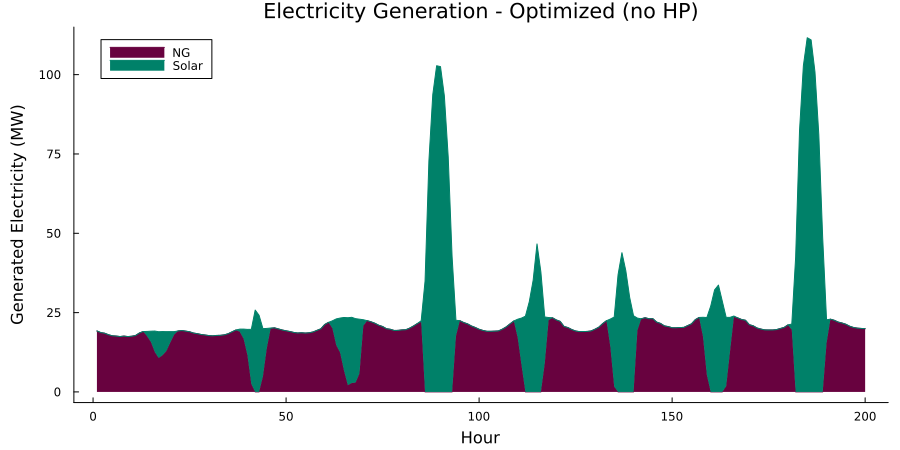

In [27]:
# Plotting natural gas and solar generation at the optimized cost
# This is just optimizing to meet electricity demand

gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=permutedims(gens[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, title = "Electricity Generation - Optimized (no HP)", legendcolumns=1, leftmargin=5mm, bottommargin=3mm)
plot!(p, size=(900, 450))

## Natural Gas, No Heat Pumps

#### Electricity and heat demand as is (with no heat pumps)

In [28]:
# Optimizing cost of production for electricity and heat - no heat pumps
# define sets
G = 1:nrow(gens)
H = 1:1
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
    NSE[t in T] >= 0
    NSH[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE) + NSHCost * sum(NSH)
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, heating[t in T], sum(z[:, t]) + NSH[t] >= hdemand.hdemand[t])
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
# @constraint(gencap, chpL[t in T], y[1, t] == 0.083752094*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

ArgumentError: ArgumentError: column name :Conversion_Factor not found in the data frame

In [29]:
NoHP_cost = @show objective_value(gencap)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1065


OptimizeNotCalled: OptimizeNotCalled()

In [30]:
# Cost per unit of MWh 
chp_price = @show shadow_price.(chp)

UndefVarError: UndefVarError: `chp` not defined

In [31]:
p = plot(; xlabel="Hour of Year", ylabel="Price of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -chp_price.data, linewidth=3, color=:blue)

UndefVarError: UndefVarError: `chp_price` not defined

In [32]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# constraint to meet both electricity and heat demand

# remake for more hours
nsh = value.(NSH).data 
p = areaplot(nsh[1:200,:], 
    # label=permutedims(gens[:, :Column1]), 
    xlabel = "Hour", 
    # ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Unserved load", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [33]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# constraint to meet both electricity and heat demand

# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=permutedims(gens[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Electricity Generation (no HP)", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

## Optimize for Emissions

In [34]:
# Optimizing cost of production for electricity and heat - no heat pumps
# define sets
G = 1:nrow(gens)
H = 1:1
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
    NSE[t in T] >= 0
    NSH[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :Emissions] .* sum(y[:, t] for t in T))
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t]) >= edemand.edemand[t])
@constraint(gencap, heating[t in T], sum(z[:, t])  >= hdemand.hdemand[t])
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
# @constraint(gencap, chpL[t in T], y[1, t] == 0.083752094*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

ArgumentError: ArgumentError: column name :Conversion_Factor not found in the data frame

In [35]:
NoHP_emissions = @show objective_value(gencap)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1065


OptimizeNotCalled: OptimizeNotCalled()

In [36]:
# Cost per unit of MWh 
chp_price = @show shadow_price.(chp)

UndefVarError: UndefVarError: `chp` not defined

In [37]:
p = plot(; xlabel="Hour of Year", ylabel="Emissions cost of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -chp_price.data, linewidth=3, color=:blue)

UndefVarError: UndefVarError: `chp_price` not defined

## Natural Gas, Solar, & Heat Pumps

### Looking at Electricity & Heat

In [38]:
# define sets
G = 1:nrow(gens)
H = 1:2
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
    NSE[t in T] >= 0
    NSH[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE) + NSHCost * sum(NSH)
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t]+ heat[2, :Conversion_Factor]*z[2, t])
@constraint(gencap, heating[t in T], sum(z[:, t]) + NSH[t] >= hdemand.hdemand[t])
# @constraint(gencap, chpL[t in T], 0.058223683*z[1, t] <=  y[1, t] )
# @constraint(gencap, chpU[t in T], y[1, t] <= 0.66694584*z[1, t] )
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

ArgumentError: ArgumentError: column name :Conversion_Factor not found in the data frame

In [39]:
HP_cost = @show objective_value(gencap)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1065


OptimizeNotCalled: OptimizeNotCalled()

In [40]:
heat_prod = @show value.(z)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [41]:
elec_prod = @show value.(y)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [42]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=permutedims(gens[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Electricity Generation with HP", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [43]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data'[1:200,:], 
    label=permutedims(heat[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [44]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data', 
    label=permutedims(heat[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [45]:
@show value(sum(NSE));

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [46]:
chp_price = @show shadow_price.(chp)

UndefVarError: UndefVarError: `chp` not defined

In [47]:
maximum(-chp_price.data)

UndefVarError: UndefVarError: `chp_price` not defined

In [48]:
p = plot(; xlabel="Hour of Year", ylabel="Price of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -chp_price.data, linewidth=3, color=:blue)

UndefVarError: UndefVarError: `chp_price` not defined

## Optimize for Emissions

In [49]:
# define sets
G = 1:nrow(gens)
H = 1:2
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :Emissions] .* sum(y[:, t] for t in T))
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t])>= edemand.edemand[t]+ heat[2, :Conversion_Factor]*z[2, t])
@constraint(gencap, heating[t in T], sum(z[:, t]) >= hdemand.hdemand[t])
# @constraint(gencap, chpL[t in T], 0.058223683*z[1, t] <=  y[1, t] )
# @constraint(gencap, chpU[t in T], y[1, t] <= 0.66694584*z[1, t] )
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

ArgumentError: ArgumentError: column name :Conversion_Factor not found in the data frame

In [50]:
HP_emissions = @show objective_value(gencap)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1065


OptimizeNotCalled: OptimizeNotCalled()

In [51]:
heat_prod = @show value.(z)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [52]:
elec_prod = @show value.(y)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [53]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=permutedims(gens[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Electricity Generation with HP", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [54]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data'[1:200,:], 
    label=permutedims(heat[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [55]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data', 
    label=permutedims(heat[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [56]:
@show value(sum(NSE));

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [57]:
chp_price = @show shadow_price.(chp)

UndefVarError: UndefVarError: `chp` not defined

In [58]:
maximum(-chp_price.data)

UndefVarError: UndefVarError: `chp_price` not defined

In [59]:
p = plot(; xlabel="Hour of Year", ylabel="Price of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -chp_price.data, linewidth=3, color=:blue)

UndefVarError: UndefVarError: `chp_price` not defined

## Natural Gas, Solar, & ESH

### Looking at Electricity & Heat

In [60]:
heat = heat[[1,3],:]

Row,Column1,Capacity,VarCost,Emissions,Conversion Factor (MWh/MMBTU)
,String3,Int64?,Float64?,Float64?,Float64
1,NG,30,27.5345,0.575831,0.0837521
2,ESH,missing,missing,missing,0.025708


In [61]:
# define sets
G = 1:nrow(gens)
H = 1:2
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
    NSE[t in T] >= 0
    NSH[t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE) + NSHCost * sum(NSH)
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t]+ heat[2, :Conversion_Factor]*z[2, t])
@constraint(gencap, heating[t in T], sum(z[:, t]) + NSH[t] >= hdemand.hdemand[t])
# @constraint(gencap, chpL[t in T], 0.058223683*z[1, t] <=  y[1, t] )
# @constraint(gencap, chpU[t in T], y[1, t] <= 0.66694584*z[1, t] )
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

ArgumentError: ArgumentError: column name :Conversion_Factor not found in the data frame

In [62]:
ESH_cost = @show objective_value(gencap)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1065


OptimizeNotCalled: OptimizeNotCalled()

In [63]:
heat_prod = @show value.(z)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [64]:
elec_prod = @show value.(y)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [65]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=permutedims(gens[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Electricity Generation with HP", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [66]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data'[1:200,:], 
    label=permutedims(heat[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [67]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data', 
    label=permutedims(heat[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [68]:
@show value(sum(NSE));

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [69]:
chp_price = @show shadow_price.(chp)

UndefVarError: UndefVarError: `chp` not defined

In [70]:
maximum(-chp_price.data)

UndefVarError: UndefVarError: `chp_price` not defined

In [71]:
p = plot(; xlabel="Hour of Year", ylabel="Price of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -chp_price.data, linewidth=3, color=:blue)

UndefVarError: UndefVarError: `chp_price` not defined

## Optimize for Emissions

In [72]:
# define sets
G = 1:nrow(gens)
H = 1:2
T = 1:nrow(edemand)
NSECost = 10000
NSHCost = 5000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    y[g in G, t in T] >= 0
    z[h in H, t in T] >= 0
end)

@objective(gencap, Min, 
   sum(gens[G, :Emissions] .* sum(y[:, t] for t in T))
)

# @constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= edemand.edemand[t])
@constraint(gencap, load[t in T], sum(y[:, t])>= edemand.edemand[t]+ heat[2, :Conversion_Factor]*z[2, t])
@constraint(gencap, heating[t in T], sum(z[:, t]) >= hdemand.hdemand[t])
# @constraint(gencap, chpL[t in T], 0.058223683*z[1, t] <=  y[1, t] )
# @constraint(gencap, chpU[t in T], y[1, t] <= 0.66694584*z[1, t] )
# @constraint(gencap, chp[t in T], y[1, t] >= heat[1, :Conversion_Factor]*z[1, t] )
@constraint(gencap, chp[t in T], y[1, t] == heat[1, :Conversion_Factor]*z[1, t] )

@constraint(gencap, availability[g in G, t in T], y[g, t] <= gens[g, :Capacity]*cap_factor[t,g])
optimize!(gencap)

ArgumentError: ArgumentError: column name :Conversion_Factor not found in the data frame

In [73]:
ESH_emissions = @show objective_value(gencap)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1065


OptimizeNotCalled: OptimizeNotCalled()

In [74]:
heat_prod = @show value.(z)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [75]:
elec_prod = @show value.(y)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [76]:
# THis is the plot of electricity generation with heat pumps so demand is higher
# remake for more hours
gen = value.(y).data 
p = areaplot(gen'[1:200,:], 
    label=permutedims(gens[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Electricity Generation with HP", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [77]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data'[1:200,:], 
    label=permutedims(heat[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [78]:
# Optimized cost with meeting electricity and heat demand
# remake for more hours
heat_data = value.(z).data 
p = areaplot(heat_data', 
    label=permutedims(heat[:, :Column1]), 
    xlabel = "Hour", 
    ylabel ="Heat (MW)", 
    color_palette=:mk_15,
    grid=:false,
    # ylim=(0, 100),
)
plot!(legend=:topleft, legendcolumns=1, title="Heat Power", topmargin=5mm, leftmargin=5mm, bottommargin=5mm)
plot!(p, size=(850, 450))

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [79]:
@show value(sum(NSE));

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\fenya\.julia\packages\JuMP\FEKLB\src\optimizer_interface.jl:1085


OptimizeNotCalled: OptimizeNotCalled()

In [80]:
chp_price = @show shadow_price.(chp)

UndefVarError: UndefVarError: `chp` not defined

In [81]:
maximum(-chp_price.data)

UndefVarError: UndefVarError: `chp_price` not defined

In [82]:
p = plot(; xlabel="Hour of Year", ylabel="Price of Co-production")
# p = plot(; xlabel="Time", ylabel=["The function ", L"y = 2x + 1", " is\\affine and not linear"])
# add simulated solution
plot!(p, T, -chp_price.data, linewidth=3, color=:blue)

UndefVarError: UndefVarError: `chp_price` not defined

In [83]:
NoHeat_cost

3.2318777194890766e6

In [84]:
results = DataFrame(Costs = [NoHeat_cost 
NoHP_cost
HP_cost
ESH_cost], Emissions = [NoHeat_emissions
NoHP_emissions
HP_emissions
ESH_emissions])

UndefVarError: UndefVarError: `NoHP_cost` not defined

In [85]:
# results = DataFrame([NoHeat_cost NoHeat_emissions
# NoHP_cost NoHP_emissions
# HP_cost HP_emissions
# ESH_cost ESH_emissions], :['cost','Emissions'])

In [86]:
CSV.write("Objectives.csv",results)

UndefVarError: UndefVarError: `results` not defined